## Variational density classification in Tensor Circuit

30 April 2024

Diego Useche Reyes

## GPU

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Libraries

In [2]:
!pip install tensorcircuit
!pip install git+https://github.com/diegour1/qmc.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 20.3 MB/s eta 0:00:00
  Cloning https://github.com/diegour1/qmc.git to /tmp/pip-req-build-5c9q8q4q
  Running command git clone --filter=blob:none --quiet https://github.com/diegour1/qmc.git /tmp/pip-req-build-5c9q8q4q
  Resolved https://github.com/diegour1/qmc.git to commit 4c2db4b21508f28466743eaf0b13fe70814f65dc
  Preparing metadata (setup.py) ... done
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12988 sha256=f447f7db7b60413ff292500b782a90e66fc9ed741240e4978a2b0b59023fcc85
  Stored in directory: /tmp/pip-ephem-wheel-cache-_3e1asw_/wheels/9f/94/66/55600fd5fe039b621ab7ee795c96f41946d90a9efaf4914d6e
Successfully built qmc


In [33]:
from functools import partial
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
import tensorcircuit as tc
from tensorcircuit import keras
import math
import qmc.tf.layers as qmc_layers
import qmc.tf.models as qmc_models

In [4]:
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

### Utils functions

In [5]:
# Given the eigenvalues this function return a Unitary gate which converts the |0> -> |psi_train>
def create_U_train(x_train_param, seed=0):
  np.random.seed(seed)
  size_U = len(x_train_param)
  U_train = np.zeros((size_U, size_U), dtype = np.complex128)
  x_1 = x_train_param
  U_train[:, 0] = x_1
  for i in range(1, size_U):
    x_i =  np.complex128(np.random.randn(size_U) + 1j*np.random.randn(size_U))
    for j in range(0, i):
      x_i -= x_i.dot(np.conjugate(U_train[:, j])) * U_train[:, j]
    x_i = x_i/np.linalg.norm(x_i)
    U_train[:, i] = x_i

  return U_train

In [96]:
# this function takes the number of classes and of qubits of the qmc pure, and extract the indices
# of the bit strings that correpond to the classes prediction
def indices_qubits_clases(num_qubits_param, num_classes_param):
  num_qubits_classes_temp = int(np.ceil(np.log2(num_classes_param)))
  a = [np.binary_repr(i, num_qubits_param) for i in range(2**num_qubits_param)]
  b = [(np.binary_repr(i, num_qubits_classes_temp) + "0"*(num_qubits_param - num_qubits_classes_temp)) for i in range(num_classes_param)]
  indices_temp = []
  for i in range(len(a)):
    if a[i] in b:
      indices_temp.append(i)

  return indices_temp

indices_qubits_clases(1, 2)

[0, 1]

In [203]:
from tabulate import tabulate

def evaluate_class_model(y_true_param, y_train_vqkdc, y_train_kdc, y_train_dmkdc, y_plot_expected_kdc, y_plot_expected_dmkdc, y_plot_pred, grid_size_param, head):

  # Accuracy
  accuracy_temp = accuracy_score(np.argmax(y_true_param, axis = 1), np.argmax(y_train_vqkdc, axis = 1))

  # Log-likelikehood
  def negative_log_likelihood(y_true_subparam, y_pred_subparam):
    return ((-(y_true_subparam*np.log(np.clip(y_pred_subparam, 1e-7, np.inf)))).sum())*(1./N_TRAINING_DATA)

  # Log-likelikehood kdc
  llh_kdc = negative_log_likelihood(y_true_param, y_train_kdc)

  # Log-likelikehood dmkdc
  llh_dmkdc = negative_log_likelihood(y_true_param, y_train_dmkdc)

   # Log-likelikehood vqkdc
  llh_vqkdc = negative_log_likelihood(y_true_param, y_train_vqkdc)

  # kullback-Leibler Divergence
  def kl_div(y_true_param, y_pred_param, grid_size_param2):
    return (y_true_param*np.log(y_true_param/y_pred_param)).sum()*grid_size_param2

  # kl-div kdc vs dmkdc
  kldiv_kdc_vs_dmkdc = kl_div(y_plot_expected_kdc, y_plot_expected_dmkdc, grid_size_param)

  # kl-div kdc vs vqkdc
  kldiv_kdc_vs_vqkdc = kl_div(y_plot_expected_kdc, y_plot_pred, grid_size_param)

  # kl-div dmkdc vs vqkdc
  kldiv_dmkdc_vs_vqkdc = kl_div(y_plot_expected_dmkdc, y_plot_pred, grid_size_param)

  # build table
  table = [["Accuracy:", np.round(accuracy_temp,3)], ["Negative Log-likelihood KDC:", np.round(llh_kdc,3)], ["Negative Log-likelihood DMKDC:", np.round(llh_dmkdc,3)], ["Negative Log-likelihood VQ-KDC:", np.round(llh_vqkdc,3)], ["KL-div KDC vs DMKDC:", np.round(kldiv_kdc_vs_dmkdc,3)], ["KL-div KDC vs VQ-KDC:", np.round(kldiv_kdc_vs_vqkdc,3)], ["KL-div DMKDC vs VQ-KDC:", np.round(kldiv_dmkdc_vs_vqkdc,3)]]
  headers = ['Metrics', head]
  print(tabulate(table, headers), "\n")

## Data sets

### Dataset 1

In [7]:
# Plot a 1D density example
N = 1000 * (2/3)
np.random.seed(0) # original randomseed(0)
X_1 = np.concatenate((np.random.normal(-1, 1, int(0.65 * N)),
                    np.random.normal(3, 1, int(0.35 * N))))[:, np.newaxis]
y_1 = np.zeros(len(X_1))

X_plot = np.linspace(-7, 14, 500)[:, np.newaxis]
true_dens_0 = (2/3) * (0.65 * norm(-1, 1).pdf(X_plot[:, 0])
             + 0.35 * norm(3, 1).pdf(X_plot[:, 0]))

X_1.shape, y_1.shape, X_plot.shape

((666, 1), (666,), (500, 1))

### Dataset 2

In [8]:
# Plot a 1D density example
N = (1/3)*1000
np.random.seed(0) # original randomseed(0)
X_2 = np.random.normal(6, 1, int(N))[:, np.newaxis]
y_2 = np.ones(len(X_2))


X_plot = np.linspace(-7, 14, 500)[:, np.newaxis]

true_dens_1 = (1/3)*norm(6, 1).pdf(X_plot[:, 0])

X_2.shape, y_2.shape, X_plot.shape

((333, 1), (333,), (500, 1))

In [9]:
X_train = np.concatenate((X_1, X_2))
y_train = np.concatenate((y_1, y_2))

# Select the indices for the binary classification
y_train = y_train[:, np.newaxis]
y_train_oh = tf.reshape (tf.keras.backend.one_hot(y_train, 2), (-1,2))

X_train.shape, y_train.shape, y_train_oh.shape

((999, 1), (999, 1), TensorShape([999, 2]))

## Constants

In [31]:
## Change these values accordingly

DATA_SET = "Arc" ## change dataset accordingly
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 2 # set 2 for the final experiments
GRID_SIZE = X_plot[1] - X_plot[0]

#######

GAMMA_DICT = {"Binomial": 2., "Potential 1": 4., "Potential 2": 16., "Arc": 4., "Star": 16.}
RANDOM_STATE_QRFF_DICT = {"Binomial": 324, "Potential 1": 125, "Potential 2": 178, "Arc": 7, "Star": 1224}
RANDOM_STATE_QEFF_DICT = {"Binomial": 3, "Potential 1": 15, "Potential 2": 78, "Arc": 73, "Star": 24}
EPOCHS_DICT  = {"Binomial": 50, "Potential 1": 50, "Potential 2": 50, "Arc": 50, "Star": 50}
LEARNING_RATE_DICT = {"Binomial": 0.0005, "Potential 1": 0.0005, "Potential 2": 0.005, "Arc": 0.0005, "Star": 0.0005}
GAMMA = GAMMA_DICT[DATA_SET]
RANDOM_STATE_QRFF = RANDOM_STATE_QRFF_DICT[DATA_SET]
RANDOM_STATE_QEFF = RANDOM_STATE_QEFF_DICT[DATA_SET]
LEARNING_RATE = LEARNING_RATE_DICT[DATA_SET]
EPOCHS = EPOCHS_DICT[DATA_SET]
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
N_FFS = 2**NUM_QUBITS_FFS

###
# EPOCHS = 20

DATA_SET, EPOCHS, NUM_QUBITS_FFS, NUM_ANCILLA_QUBITS, GAMMA, RANDOM_STATE_QRFF, RANDOM_STATE_QEFF, DIM_X, N_FFS, LEARNING_RATE, N_TRAINING_DATA

('Arc', 50, 5, 2, 4.0, 7, 73, 1, 32, 0.0005, 999)

## Raw KDC

In [55]:
GAMMA = float(2**2)

def kernel_density_classification(X_train_param, Y_train_oh_param, X_test_param, gamma_param = 4.):

  ## Initialize values
  Y_train_oh_param = np.array(Y_train_oh_param)
  num_classes_temp = Y_train_oh_param.shape[1]
  Y_pred_temp = np.zeros((len(X_test_param), num_classes_temp))
  sigma_temp = 1./(np.sqrt(2.*gamma_param))

  ## Training
  kde_temp = []
  for j in range(num_classes_temp):
    kde_temp.append(KernelDensity(kernel='gaussian', bandwidth=sigma_temp).fit(X_train[Y_train_oh_param[:, j].astype(bool)]))

  ## Prediction
  for j in range(num_classes_temp):
    Y_pred_temp[:, j] =  (Y_train_oh_param[:, j].sum()/len(Y_train_oh_param))*np.exp(kde_temp[j].score_samples(X_test_param))

  return Y_pred_temp

preds_plot_kdc = kernel_density_classification(X_train, y_train_oh, X_plot, gamma_param = GAMMA)
preds_train_kdc = kernel_density_classification(X_train, y_train_oh, X_train, gamma_param = GAMMA)

Text(0, 0.5, 'Probability Density')

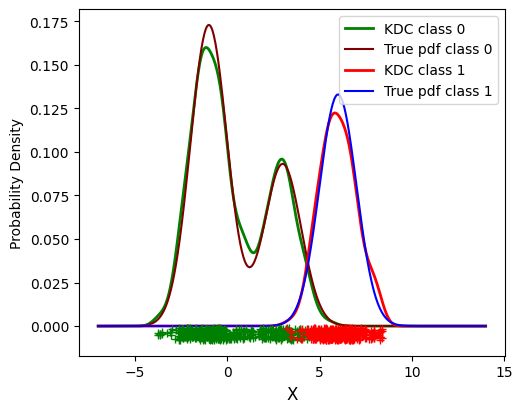

In [56]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

#plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot, preds_plot_kdc[:, 0], color='green', lw=lw,
           linestyle='-', label=f"KDC class 0")
plt.plot(X_plot, true_dens_0, "maroon", label='True pdf class 0')
plt.plot(X_plot, preds_plot_kdc[:, 1], color='red', lw=lw,
           linestyle='-', label=f"KDC class 1")
plt.plot(X_plot, true_dens_1, "blue", label='True pdf class 1')
indexes_class0 = np.random.randint(0, len(X_1), 500)
plt.plot(X_1[indexes_class0], -0.00125 - 0.00675 * np.random.random(len(indexes_class0)), '+g')
indexes_class1 = np.random.randint(0, len(X_2), 500)
plt.plot(X_2[indexes_class1], -0.00125 - 0.00675 * np.random.random(len(indexes_class1)), '+r')
plt.legend(loc='best')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

## Classical DMKDC QRFF

In [84]:
GAMMA = float(2**2) ### original 2**2
N_FFS = 32 ### original 32

def classical_dmkdc_qrff(X_train_param, Y_train_oh_param, X_test_param, n_qrffs_param, rs_param, gamma_param = 4.):

  ## Initialize values
  dim_x_temp = X_train_param.shape[1]
  Y_train_oh_param = np.array(Y_train_oh_param)
  num_classes_temp = Y_train_oh_param.shape[1]
  Y_pred_temp = np.zeros((len(X_test_param), num_classes_temp))
  sigma_temp = 1./(np.sqrt(2.*gamma_param))

  ## Training
  dmkdc_temp = []
  for j in range(num_classes_temp):
    fm_x = qmc_layers.QFeatureMapComplexRFF(dim_x_temp, dim=n_qrffs_param, gamma=gamma_param/2, random_state= rs_param)
    dmkdc_temp.append(qmc_models.ComplexQMDensity(fm_x, n_qrffs_param))

  ## Prediction
  for j in range(num_classes_temp):
    dmkdc_temp[j].compile()
    dmkdc_temp[j].fit(X_train_param[Y_train_oh_param[:, j].astype(bool)], epochs=1)
    Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))

  return ((y_train_oh.numpy().sum(axis=0)/len(y_train_oh)))*Y_pred_temp

preds_plot_dmkdc = classical_dmkdc_qrff(X_train, y_train_oh, X_plot, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QRFF, gamma_param = GAMMA)
preds_train_dmkdc = classical_dmkdc_qrff(X_train, y_train_oh, X_train, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QRFF, gamma_param = GAMMA)

16/16 [==============================] - 0s 2ms/step


<ipython-input-84-2804f0c5e921>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


16/16 [==============================] - 0s 2ms/step


<ipython-input-84-2804f0c5e921>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


32/32 [==============================] - 0s 2ms/step


<ipython-input-84-2804f0c5e921>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


32/32 [==============================] - 0s 2ms/step


<ipython-input-84-2804f0c5e921>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param))


Text(0, 0.5, 'Probability Density')

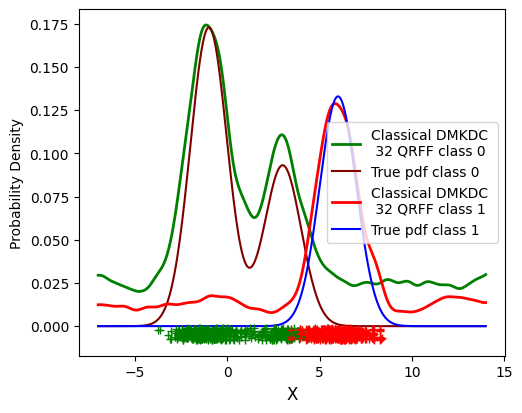

In [85]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

#plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot, preds_plot_dmkdc[:, 0], color='green', lw=lw,
           linestyle='-', label=f"Classical DMKDC \n {N_FFS} QRFF class 0")
plt.plot(X_plot, true_dens_0, "maroon", label='True pdf class 0')
plt.plot(X_plot, preds_plot_dmkdc[:, 1], color='red', lw=lw,
           linestyle='-', label=f"Classical DMKDC \n {N_FFS} QRFF class 1")
plt.plot(X_plot, true_dens_1, "blue", label='True pdf class 1')
indexes_class0 = np.random.randint(0, len(X_1), 500)
plt.plot(X_1[indexes_class0], -0.00125 - 0.00675 * np.random.random(len(indexes_class0)), '+g')
indexes_class1 = np.random.randint(0, len(X_2), 500)
plt.plot(X_2[indexes_class1], -0.00125 - 0.00675 * np.random.random(len(indexes_class1)), '+r')
plt.legend(loc='best')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

## Classical DMKDC QEFF

In [90]:
import qmc.tf.layers as qmc_layers
import qmc.tf.models as qmc_models

In [91]:

tc.set_backend("tensorflow")
tc.set_dtype("complex128")

class QFeatureMapQuantumEnhancedFF(tf.keras.layers.Layer):
    """Quantum feature map including the complex part of random Fourier Features.
    Uses `RBFSampler` from sklearn to approximate an RBF kernel using
    complex random Fourier features.

    Input shape:
        (batch_size, dim_in)
    Output shape:
        (batch_size, dim)
    Arguments:
        input_dim: dimension of the input
        dim: int. Number of dimensions to represent a sample.
        gamma: float. Gamma parameter of the RBF kernel to be approximated.
        random_state: random number generator seed.
    """

    def __init__(
            self,
            input_dim: int,
            dim: int = 100,
            gamma: float = 0.5,
            random_state=None,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.dim = dim
        self.gamma = gamma
        self.random_state = random_state


    def build(self, input_shape):
        self.qeff_weights = tf.random.normal((self.input_dim, int(self.dim*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.dim - 1), dtype=tf.dtypes.float64, seed = self.random_state) ## final model self.qeff_weights = tf.random.normal((self.input_dim, int(self.dim*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.dim - 1), dtype=tf.dtypes.float64, seed = self.random_state)
        self.built = True

    def call(self, inputs):

        ### build the phases of QEFF
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(inputs, tf.float64), self.qeff_weights))[0]

        ### indices qeff for iterator
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ## build QEFF circuit
        self.n_qeff_qubits = int(np.ceil(np.log2(self.dim)))
        self.circuit = tc.Circuit(self.n_qeff_qubits)

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(0, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(0, target_qubit_param)
            qc_param.rz(target_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param)
            qc_param.cnot(num_qubits_param-2, target_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in range(0, self.n_qeff_qubits):
          self.circuit.H(i)

        for i in range(1, self.n_qeff_qubits + 1):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1)

        psi = tf.cast(tf.expand_dims(self.circuit.state(), axis=0), tf.complex64)
        return psi

    def get_config(self):
        config = {
            "input_dim": self.input_dim,
            "dim": self.dim,
            "gamma": self.gamma,
            "random_state": self.random_state
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dim)

In [94]:
GAMMA = float(2**2) ### original 2**2
N_FFS = 32 ### original 32

def classical_dmkdc_qeff(X_train_param, Y_train_oh_param, X_test_param, n_qrffs_param, rs_param, gamma_param = 4.):

  ## Initialize values
  dim_x_temp = X_train_param.shape[1]
  Y_train_oh_param = np.array(Y_train_oh_param)
  num_classes_temp = Y_train_oh_param.shape[1]
  Y_pred_temp = np.zeros((len(X_test_param), num_classes_temp))
  sigma_temp = 1./(np.sqrt(2.*gamma_param))

  ## Training
  dmkdc_temp = []
  fm_x = QFeatureMapQuantumEnhancedFF(dim_x_temp, dim=n_qrffs_param, gamma=gamma_param, random_state= rs_param)
  for j in range(num_classes_temp):
    dmkdc_temp.append(qmc_models.ComplexQMDensity(fm_x, n_qrffs_param))

  ## Prediction
  for j in range(num_classes_temp):
    dmkdc_temp[j].compile()
    dmkdc_temp[j].fit(X_train_param[Y_train_oh_param[:, j].astype(bool)], epochs=1, batch_size = 1) ### must keep the batch size = 1
    Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param, batch_size = 1)) ### must keep the batch size = 1

  return ((y_train_oh.numpy().sum(axis=0)/len(y_train_oh)))*Y_pred_temp

preds_train_dmkdc_qeff = classical_dmkdc_qeff(X_train, y_train_oh, X_train, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QRFF, gamma_param = GAMMA)
preds_plot_dmkdc_qeff = classical_dmkdc_qeff(X_train, y_train_oh, X_plot, n_qrffs_param = N_FFS, rs_param = RANDOM_STATE_QRFF, gamma_param = GAMMA)

999/999 [==============================] - 11s 2ms/step


<ipython-input-94-8511054571a5>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_pred_temp[:, j] = ((gamma_param/np.pi)**(dim_x_temp/2))*(dmkdc_temp[j].predict(X_test_param, batch_size = 1)) ### must keep the batch size = 1


500/500 [==============================] - 11s 2ms/step


Text(0, 0.5, 'Probability Density')

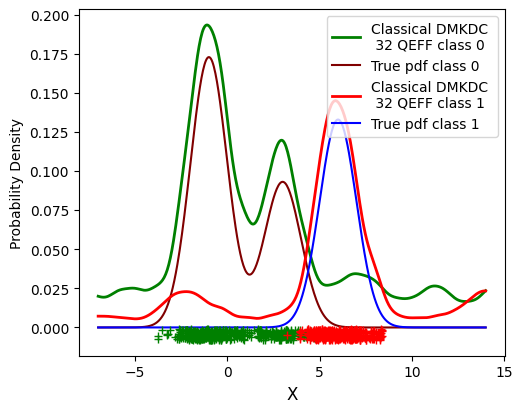

In [95]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

#plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot, preds_plot_dmkdc_qeff[:, 0], color='green', lw=lw,
           linestyle='-', label=f"Classical DMKDC \n {N_FFS} QEFF class 0")
plt.plot(X_plot, true_dens_0, "maroon", label='True pdf class 0')
plt.plot(X_plot, preds_plot_dmkdc_qeff[:, 1], color='red', lw=lw,
           linestyle='-', label=f"Classical DMKDC \n {N_FFS} QEFF class 1")
plt.plot(X_plot, true_dens_1, "blue", label='True pdf class 1')
indexes_class0 = np.random.randint(0, len(X_1), 500)
plt.plot(X_1[indexes_class0], -0.00125 - 0.00675 * np.random.random(len(indexes_class0)), '+g')
indexes_class1 = np.random.randint(0, len(X_2), 500)
plt.plot(X_2[indexes_class1], -0.00125 - 0.00675 * np.random.random(len(indexes_class1)), '+r')
plt.legend(loc='best')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

## Mixed VQ-KCD, QRFF

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, no-conv layer

In [19]:
# this function takes the number of classes and of qubits of the qmc pure, and extract the indices
# of the bit strings that correpond to the classes prediction
def indices_qubits_clases(num_qubits_param, num_classes_param):
  num_qubits_classes_temp = int(np.ceil(np.log2(num_classes_param)))
  a = [np.binary_repr(i, num_qubits_param) for i in range(2**num_qubits_param)]
  b = [(np.binary_repr(i, num_qubits_classes_temp) + "0"*(num_qubits_param - num_qubits_classes_temp)) for i in range(num_classes_param)]
  indices_temp = []
  for i in range(len(a)):
    if a[i] in b:
      indices_temp.append(i)

  return indices_temp

indices_qubits_clases(1, 2)

[0, 1]

In [20]:
r = np.random.RandomState(RANDOM_STATE_QRFF)
weights_ffs_temp = r.normal(0, 1, (DIM_X, N_FFS))

weights_ffs_temp.mean(), weights_ffs_temp.std(), weights_ffs_temp.shape

(-0.05818188592975178, 0.9901717926588047, (1, 32))

In [21]:
### constants
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 2 # set 2 for the final experiments
NUM_CLASSES_QUBITS = 1
NUM_CLASSES = 2
GAMMA = float(2**2) # originally 2**(-4)
EPOCHS = 50
LEARNING_RATE = 0.005
RANDOM_STATE = 67
BATCH_SIZE = 16

In [22]:
def predict_features(X_param, var_param, gamma_param):
  X_feat = np.ones((len(X_param), var_param.shape[1]), dtype = np.complex128)
  X_feat[:, :] = np.cos(np.sqrt(gamma_param)*(X_param @ var_param)) - 1j*np.sin(np.sqrt(gamma_param)*(X_param @ var_param))
  X_feat *= np.sqrt(1/(var_param.shape[1]))
  return X_feat

X_feat_train_class0 = np.kron(np.array([1, 0]), predict_features(X_1, weights_ffs_temp, GAMMA))
X_feat_train_class1 = np.kron(np.array([0, 1]), predict_features(X_2, weights_ffs_temp, GAMMA))
X_feat_train = predict_features(X_train, weights_ffs_temp, GAMMA)
X_feat_test = predict_features(X_plot, weights_ffs_temp, GAMMA)

X_feat_train.shape, X_feat_test.shape, X_train.shape, X_feat_test.shape

((999, 32), (500, 32), (999, 1), (500, 32))

In [23]:
## Convert states to unitaries (3,5 mins with 10000)

U_train_conjTrans = np.array([np.conjugate(create_U_train(X_feat_train[i]).T) for i in range(len(X_feat_train))])
U_test_conjTrans = np.array([np.conjugate(create_U_train(X_feat_test[i]).T) for i in range(len(X_feat_test))])

U_train_conjTrans.shape, U_test_conjTrans.shape

((999, 32, 32), (500, 32, 32))

In [24]:
### Quantum variational KDC with QRFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QRFF:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, batch_size = 16, learning_rate = 0.0005, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_pure_state_parameters_size = 2*(2**self.n_total_qubits_temp - 1)
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_pure_state_parameters_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            U_dagger,
            var_pure_state_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state
        index_it = iter(np.arange(len(var_pure_state_param)))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def circuit_base_ry_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.ry(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        def circuit_base_rz_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.rz(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        # Learning pure state
        for i in range(1, self.n_total_qubits_temp+1):
            circuit_base_ry_n(self.circuit, i, i-1)

        # Learning pure state complex phase
        for j in range(1, self.n_total_qubits_temp+1):
            circuit_base_rz_n(self.circuit, j, j-1)

        # Value to predict
        self.circuit.any(
            *[n for n in range(self.num_classes_qubits, self.n_qeff_qubits + self.num_classes_qubits)], unitary=U_dagger
        )

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0)
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [25]:
## training the quantum circuit
vqkdc = VQKDC_MIXED_QRFF(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE)

vqkdc.fit(U_train_conjTrans, y_train_oh, epochs = EPOCHS)

Epoch 1/100
63/63 [==============================] - 278s 58ms/step - loss: 0.0051 - accuracy: 0.6667
Epoch 2/100
63/63 [==============================] - 3s 54ms/step - loss: 0.0039 - accuracy: 0.6667
Epoch 3/100
63/63 [==============================] - 3s 43ms/step - loss: 0.0033 - accuracy: 0.6667
Epoch 4/100
63/63 [==============================] - 3s 43ms/step - loss: 0.0029 - accuracy: 0.6667
Epoch 5/100
63/63 [==============================] - 3s 44ms/step - loss: 0.0027 - accuracy: 0.6807
Epoch 6/100
63/63 [==============================] - 5s 78ms/step - loss: 0.0025 - accuracy: 0.7788
Epoch 7/100
63/63 [==============================] - 4s 59ms/step - loss: 0.0024 - accuracy: 0.8478
Epoch 8/100
63/63 [==============================] - 3s 42ms/step - loss: 0.0024 - accuracy: 0.8759
Epoch 9/100
63/63 [==============================] - 3s 47ms/step - loss: 0.0023 - accuracy: 0.9069
Epoch 10/100
63/63 [==============================] - 4s 67ms/step - loss: 0.0023 - accuracy: 0.91

KeyboardInterrupt: 

In [76]:
preds_plot = vqkdc.predict(U_test_conjTrans)
preds_train = vqkdc.predict(U_train_conjTrans)

preds_train.shape, preds_plot.shape

32/32 [==============================] - 1s 23ms/step


((999, 2), (500, 2))

Text(0, 0.5, 'Probability Density')

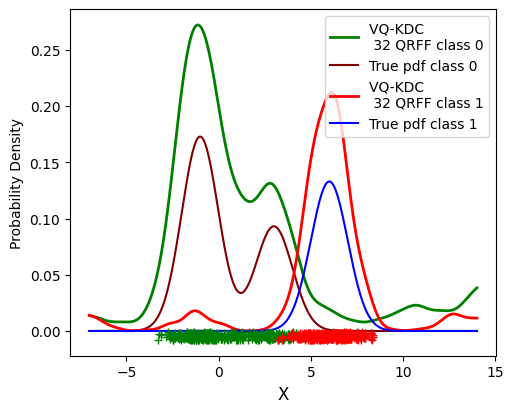

In [112]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

#plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot, preds_plot[:, 0], color='green', lw=lw,
           linestyle='-', label=f"VQ-KDC \n {2**NUM_QUBITS_FFS} QRFF class 0")
plt.plot(X_plot, true_dens_0, "maroon", label='True pdf class 0')
plt.plot(X_plot, preds_plot[:, 1], color='red', lw=lw,
           linestyle='-', label=f"VQ-KDC \n {2**NUM_QUBITS_FFS} QRFF class 1")
plt.plot(X_plot, true_dens_1, "blue", label='True pdf class 1')
indexes_class0 = np.random.randint(0, len(X_1), 500)
plt.plot(X_1[indexes_class0], -0.00125 - 0.00675 * np.random.random(len(indexes_class0)), '+g')
indexes_class1 = np.random.randint(0, len(X_2), 500)
plt.plot(X_2[indexes_class1], -0.00125 - 0.00675 * np.random.random(len(indexes_class1)), '+r')
plt.legend(loc='best')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

### Evaluate

In [204]:
### evaluate metrics
evaluate_class_model(y_true_param = y_train_oh.numpy(), y_train_vqkdc = preds_train, y_train_kdc = preds_train_kdc, y_train_dmkdc = preds_train_dmkdc, y_plot_expected_kdc = preds_plot_kdc, y_plot_expected_dmkdc = preds_plot_dmkdc, y_plot_pred = preds_plot, grid_size_param = GRID_SIZE, head = f"VQ-KDC {2**NUM_QUBITS_FFS} QRFF vs KDC and DMKDC")

Metrics                            VQ-KDC 32 QRFF vs KDC and DMKDC
-------------------------------  ---------------------------------
Accuracy:                                                    0.974
Negative Log-likelihood KDC:                                 2.428
Negative Log-likelihood DMKDC:                               2.244
Negative Log-likelihood VQ-KDC:                              1.83
KL-div KDC vs DMKDC:                                        -0.202
KL-div KDC vs VQ-KDC:                                       -0.614
KL-div DMKDC vs VQ-KDC:                                     -0.103 



## Mixed VQ-KCD, QEFF

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, no-conv layer

In [97]:
### Quantum variational KDC with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QEFF:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, batch_size = 16, learning_rate = 0.0005, random_state = 15, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_pure_state_parameters_size = 2*(2**self.n_total_qubits_temp - 1)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.qeff_weights = tf.random.normal((dim_x_param, int(self.num_ffs*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.num_ffs - 1), dtype=tf.dtypes.float64, seed = random_state)

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_pure_state_parameters_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_pure_state_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state
        index_it = iter(np.arange(len(var_pure_state_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes


        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def circuit_base_ry_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.ry(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.ry(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_ry_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        def circuit_base_rz_n(qc_param, num_qubits_param, target_qubit_param):
            if num_qubits_param == 1:
                qc_param.rz(0, theta = var_pure_state_param[next(index_it)])
            elif num_qubits_param == 2:
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                qc_param.cnot(0, target_qubit_param)
                qc_param.rz(target_qubit_param, theta=var_pure_state_param[next(index_it)])
                return
            else:
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                qc_param.cnot(num_qubits_param-2, target_qubit_param)
                circuit_base_rz_n(qc_param, num_qubits_param-1, target_qubit_param)
                target_qubit_param -= 1

        # Learning pure state
        for i in range(1, self.n_total_qubits_temp+1):
            circuit_base_ry_n(self.circuit, i, i-1)

        # Learning pure state complex phase
        for j in range(1, self.n_total_qubits_temp+1):
            circuit_base_rz_n(self.circuit, j, j-1)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights))[0]
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2 + init_qubit_param, target_qubit_param + init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in reversed(range(1, self.n_qeff_qubits + 1)):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_qeff_qubits):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [98]:
### constants
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 1 # set 2 for the final experiments
NUM_CLASSES_QUBITS = 1
NUM_CLASSES = 2
GAMMA = float(2**2) # originally 2**(-4)
EPOCHS = 100
LEARNING_RATE = 0.005
RANDOM_STATE = 67
BATCH_SIZE = 16

## training the quantum circuit
vqkdc = VQKDC_MIXED_QEFF(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE, random_state = RANDOM_STATE)

vqkdc.fit(X_train, y_train_oh, epochs = EPOCHS)

Epoch 1/100
63/63 [==============================] - 237s 27ms/step - loss: 0.0047 - accuracy: 0.6667
Epoch 2/100
63/63 [==============================] - 2s 27ms/step - loss: 0.0034 - accuracy: 0.6667
Epoch 3/100
63/63 [==============================] - 2s 39ms/step - loss: 0.0027 - accuracy: 0.7227
Epoch 4/100
63/63 [==============================] - 3s 41ms/step - loss: 0.0024 - accuracy: 0.8699
Epoch 5/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0021 - accuracy: 0.8979
Epoch 6/100
63/63 [==============================] - 2s 27ms/step - loss: 0.0019 - accuracy: 0.9319
Epoch 7/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0019 - accuracy: 0.9429
Epoch 8/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0019 - accuracy: 0.9550
Epoch 9/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0018 - accuracy: 0.9650
Epoch 10/100
63/63 [==============================] - 2s 33ms/step - loss: 0.0018 - accuracy: 0.96

In [99]:
preds_plot_vqkdc_qeff = vqkdc.predict(X_plot)
preds_train_vqkdc_qeff = vqkdc.predict(X_train)

preds_plot_vqkdc_qeff.shape, preds_train_vqkdc_qeff.shape

32/32 [==============================] - 1s 17ms/step


(500, 2)

Text(0, 0.5, 'Probability Density')

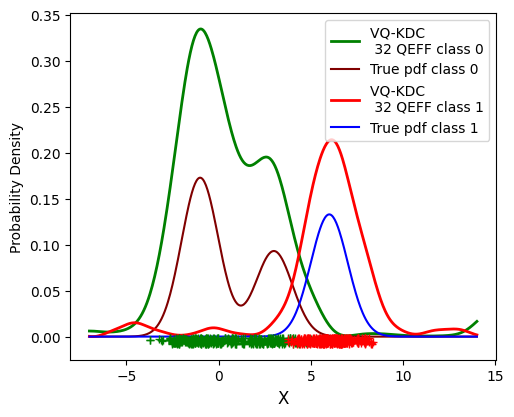

In [102]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

#plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot, preds_plot_vqkdc_qeff[:, 0], color='green', lw=lw,
           linestyle='-', label=f"VQ-KDC \n {2**NUM_QUBITS_FFS} QEFF class 0")
plt.plot(X_plot, true_dens_0, "maroon", label='True pdf class 0')
plt.plot(X_plot, preds_plot_vqkdc_qeff[:, 1], color='red', lw=lw,
           linestyle='-', label=f"VQ-KDC \n {2**NUM_QUBITS_FFS} QEFF class 1")
plt.plot(X_plot, true_dens_1, "blue", label='True pdf class 1')
indexes_class0 = np.random.randint(0, len(X_1), 500)
plt.plot(X_1[indexes_class0], -0.00125 - 0.00675 * np.random.random(len(indexes_class0)), '+g')
indexes_class1 = np.random.randint(0, len(X_2), 500)
plt.plot(X_2[indexes_class1], -0.00125 - 0.00675 * np.random.random(len(indexes_class1)), '+r')
plt.legend(loc='best')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

### Evaluate

In [205]:
### evaluate metrics
evaluate_class_model(y_true_param = y_train_oh.numpy(), y_train_vqkdc = preds_train_vqkdc_qeff, y_train_kdc = preds_train_kdc, y_train_dmkdc = preds_train_dmkdc_qeff, y_plot_expected_kdc = preds_plot_kdc, y_plot_expected_dmkdc = preds_plot_dmkdc_qeff, y_plot_pred = preds_plot_vqkdc_qeff, grid_size_param = GRID_SIZE, head = f"VQ-KDC {2**NUM_QUBITS_FFS} QEFF vs KDC and DMKDC")

Metrics                            VQ-KDC 32 QEFF vs KDC and DMKDC
-------------------------------  ---------------------------------
Accuracy:                                                    0.976
Negative Log-likelihood KDC:                                 2.428
Negative Log-likelihood DMKDC:                               2.311
Negative Log-likelihood VQ-KDC:                              1.823
KL-div KDC vs DMKDC:                                        -0.277
KL-div KDC vs VQ-KDC:                                       -0.865
KL-div DMKDC vs VQ-KDC:                                     -0.067 



## Constants HEA

In [206]:
## Change these values accordingly

DATA_SET = "Potential 2" ## change dataset accordingly
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 2 # set 2 for the final experiments

#######

GAMMA_DICT = {"Binomial": 2., "Potential 1": 4., "Potential 2": 16., "Arc": 4., "Star": 16.}
RANDOM_STATE_QRFF_DICT = {"Binomial": 324, "Potential 1": 125, "Potential 2": 178, "Arc": 7, "Star": 1224}
RANDOM_STATE_QEFF_DICT = {"Binomial": 3, "Potential 1": 15, "Potential 2": 78, "Arc": 73, "Star": 24}
EPOCHS_DICT  = {"Binomial": 0, "Potential 1": 8, "Potential 2": 60, "Arc": 60, "Star": 60}
LEARNING_RATE_DICT = {"Binomial": 0.0005, "Potential 1": 0.0005, "Potential 2": 0.005, "Arc": 0.0005, "Star": 0.0005}
GAMMA = GAMMA_DICT[DATA_SET]
RANDOM_STATE_QRFF = RANDOM_STATE_QRFF_DICT[DATA_SET]
RANDOM_STATE_QEFF = RANDOM_STATE_QEFF_DICT[DATA_SET]
LEARNING_RATE = LEARNING_RATE_DICT[DATA_SET]
EPOCHS = EPOCHS_DICT[DATA_SET]
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
N_FFS = 2**NUM_QUBITS_FFS
NUM_LAYERS_HEA = 3 ## set 3 for the final experiments
NUM_TOTAL_QUBITS = NUM_QUBITS_FFS + NUM_ANCILLA_QUBITS

###
#EPOCHS = 20


DATA_SET, EPOCHS, NUM_QUBITS_FFS, NUM_ANCILLA_QUBITS, GAMMA, RANDOM_STATE_QRFF, RANDOM_STATE_QEFF, DIM_X, N_FFS, NUM_LAYERS_HEA, LEARNING_RATE, N_TRAINING_DATA


('Potential 2', 60, 5, 2, 16.0, 178, 78, 1, 32, 3, 0.005, 999)

## Mixed VQ-KCD, QRFF HEA

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, no-conv layer

In [207]:
r = np.random.RandomState(RANDOM_STATE_QRFF)
weights_ffs_temp = r.normal(0, 1, (DIM_X, N_FFS))

weights_ffs_temp.mean(), weights_ffs_temp.std(), weights_ffs_temp.shape

(0.16338279289690802, 0.8571118668822301, (1, 32))

In [208]:
### constants
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 2 # set 2 for the final experiments
NUM_CLASSES_QUBITS = 1
NUM_CLASSES = 2
GAMMA = float(2**2) # originally 2**(-4)
EPOCHS = 100
LEARNING_RATE = 0.005
RANDOM_STATE = 67
BATCH_SIZE = 16

In [209]:
def predict_features(X_param, var_param, gamma_param):
  X_feat = np.ones((len(X_param), var_param.shape[1]), dtype = np.complex128)
  X_feat[:, :] = np.cos(np.sqrt(gamma_param)*(X_param @ var_param)) - 1j*np.sin(np.sqrt(gamma_param)*(X_param @ var_param))
  X_feat *= np.sqrt(1/(var_param.shape[1]))
  return X_feat

X_feat_train_class0 = np.kron(np.array([1, 0]), predict_features(X_1, weights_ffs_temp, GAMMA))
X_feat_train_class1 = np.kron(np.array([0, 1]), predict_features(X_2, weights_ffs_temp, GAMMA))
X_feat_train = predict_features(X_train, weights_ffs_temp, GAMMA)
X_feat_test = predict_features(X_plot, weights_ffs_temp, GAMMA)

X_feat_train.shape, X_feat_test.shape, X_train.shape, X_feat_test.shape

((999, 32), (500, 32), (999, 1), (500, 32))

In [210]:
## Convert states to unitaries (3,5 mins with 10000)

U_train_conjTrans = np.array([np.conjugate(create_U_train(X_feat_train[i]).T) for i in range(len(X_feat_train))])
U_test_conjTrans = np.array([np.conjugate(create_U_train(X_feat_test[i]).T) for i in range(len(X_feat_test))])

U_train_conjTrans.shape, U_test_conjTrans.shape

KeyboardInterrupt: 

In [211]:
### Quantum variational KDC with QRFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QRFF_HEA:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            U_dagger,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes

        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)


        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict
        self.circuit.any(
            *[n for n in range(self.num_classes_qubits, self.n_qeff_qubits + self.num_classes_qubits)], unitary=U_dagger
        )

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0)
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [212]:
### constants
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 1 # set 2 for the final experiments
NUM_CLASSES_QUBITS = 1
NUM_CLASSES = 2
GAMMA = float(2**2) # originally 2**(-4)
EPOCHS = 100
LEARNING_RATE = 0.001
RANDOM_STATE = 67
BATCH_SIZE = 16

## training the quantum circuit
vqkdc = VQKDC_MIXED_QRFF_HEA(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE)

vqkdc.fit(U_train_conjTrans, y_train_oh, epochs = EPOCHS)

Epoch 1/100
63/63 [==============================] - 26s 20ms/step - loss: 0.0049 - accuracy: 0.6667
Epoch 2/100
63/63 [==============================] - 1s 20ms/step - loss: 0.0046 - accuracy: 0.6667
Epoch 3/100
63/63 [==============================] - 1s 20ms/step - loss: 0.0044 - accuracy: 0.6667
Epoch 4/100
63/63 [==============================] - 1s 19ms/step - loss: 0.0043 - accuracy: 0.6667
Epoch 5/100
63/63 [==============================] - 2s 28ms/step - loss: 0.0042 - accuracy: 0.6637
Epoch 6/100
63/63 [==============================] - 3s 49ms/step - loss: 0.0041 - accuracy: 0.6547
Epoch 7/100
63/63 [==============================] - 3s 45ms/step - loss: 0.0040 - accuracy: 0.6486
Epoch 8/100
63/63 [==============================] - 3s 41ms/step - loss: 0.0039 - accuracy: 0.6446
Epoch 9/100
63/63 [==============================] - 2s 38ms/step - loss: 0.0038 - accuracy: 0.6416
Epoch 10/100
63/63 [==============================] - 3s 46ms/step - loss: 0.0037 - accuracy: 0.645

In [213]:
preds_plot_vqkdc_qrff_hea = vqkdc.predict(U_test_conjTrans)
preds_train_vqkdc_qrff_hea = vqkdc.predict(U_train_conjTrans)

preds_train_vqkdc_qrff_hea.shape, preds_plot_vqkdc_qrff_hea.shape

32/32 [==============================] - 1s 17ms/step


((999, 2), (500, 2))

Text(0, 0.5, 'Probability Density')

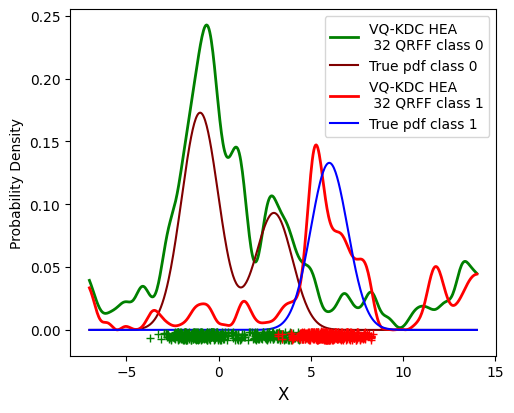

In [214]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

#plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot, preds_plot_vqkdc_qrff_hea[:, 0], color='green', lw=lw,
           linestyle='-', label=f"VQ-KDC HEA \n {2**NUM_QUBITS_FFS} QRFF class 0")
plt.plot(X_plot, true_dens_0, "maroon", label='True pdf class 0')
plt.plot(X_plot, preds_plot_vqkdc_qrff_hea[:, 1], color='red', lw=lw,
           linestyle='-', label=f"VQ-KDC HEA \n {2**NUM_QUBITS_FFS} QRFF class 1")
plt.plot(X_plot, true_dens_1, "blue", label='True pdf class 1')
indexes_class0 = np.random.randint(0, len(X_1), 500)
plt.plot(X_1[indexes_class0], -0.00125 - 0.00675 * np.random.random(len(indexes_class0)), '+g')
indexes_class1 = np.random.randint(0, len(X_2), 500)
plt.plot(X_2[indexes_class1], -0.00125 - 0.00675 * np.random.random(len(indexes_class1)), '+r')
plt.legend(loc='best')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

### Evaluate

In [215]:
### evaluate metrics
evaluate_class_model(y_true_param = y_train_oh.numpy(), y_train_vqkdc = preds_train_vqkdc_qrff_hea, y_train_kdc = preds_train_kdc, y_train_dmkdc = preds_train_dmkdc, y_plot_expected_kdc = preds_plot_kdc, y_plot_expected_dmkdc = preds_plot_dmkdc, y_plot_pred = preds_plot_vqkdc_qrff_hea, grid_size_param = GRID_SIZE, head = f"VQ-KDC {2**NUM_QUBITS_FFS} QEFF vs KDC and DMKDC")

Metrics                            VQ-KDC 32 QEFF vs KDC and DMKDC
-------------------------------  ---------------------------------
Accuracy:                                                    0.969
Negative Log-likelihood KDC:                                 2.428
Negative Log-likelihood DMKDC:                               2.244
Negative Log-likelihood VQ-KDC:                              2.187
KL-div KDC vs DMKDC:                                        -0.202
KL-div KDC vs VQ-KDC:                                       -0.258
KL-div DMKDC vs VQ-KDC:                                      0.104 



## Mixed VQ-KCD, QEFF, HEA

Ten classes MNIST Classification, QMC variational, with quantum-enhanced Fourier features, and Hardware Efficient Ansatz

In [217]:
### Quantum variational KDC with QEFF

import tensorcircuit as tc
from tensorcircuit import keras
import tensorflow as tf

from functools import partial
import numpy as np
import math as m
from scipy.stats import entropy, spearmanr



tc.set_backend("tensorflow")
tc.set_dtype("complex128")

pi = tf.constant(m.pi)


class VQKDC_MIXED_QEFF_HEA:
    r"""
    Defines the ready-to-use Quantum measurement classification (QMC) model implemented
    in TensorCircuit using the TensorFlow/Keras API. Any additional argument in the methods has to be Keras-compliant.

    Args:
        auto_compile: A boolean to autocompile the model using default settings. (Default True).
        var_pure_state_size:
        gamma:

    Returns:
        An instantiated model ready to train with ad-hoc data.

    """
    def __init__(self, dim_x_param, n_qeff_qubits, n_ancilla_qubits, num_classes_qubits, num_classes_param, gamma, n_training_data, num_layers_hea = 3, batch_size = 16, learning_rate = 0.0005, random_state = 15, auto_compile=True):

        self.circuit = None
        self.gamma = gamma
        self.dim_x = dim_x_param
        self.num_layers_hea = num_layers_hea
        self.num_classes = num_classes_param
        self.num_classes_qubits = num_classes_qubits
        self.n_qeff_qubits = n_qeff_qubits
        self.n_ancilla_qubits = n_ancilla_qubits
        self.n_total_qubits_temp = self.num_classes_qubits + self.n_qeff_qubits + self.n_ancilla_qubits
        self.num_ffs = 2**self.n_qeff_qubits
        self.n_training_data = n_training_data
        self.var_hea_ansatz_size = int(self.n_total_qubits_temp*(self.num_layers_hea+1)*2)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.qeff_weights = tf.random.normal((dim_x_param, int(self.num_ffs*1-1)), mean = 0.0, stddev = 2.0/np.sqrt(self.num_ffs - 1), dtype=tf.dtypes.float64, seed = random_state)

        layer = keras.QuantumLayer(
            partial(self.layer),
            [(self.var_hea_ansatz_size,)]
            )

        self.model = tf.keras.Sequential([layer])

        if auto_compile:
            self.compile()

    def layer(
            self,
            x_sample_param,
            var_hea_ansatz_param,
        ):
        r"""
        Defines a Density Matrix Kernel Density Estimation quantum layer for learning with fixed qaff (Meaning of qaff?). (This function was originally named dmkde_mixed_variational_density_estimation_fixed_qaff)

        Args:
            U_dagger:
            var_pure_state_param:

        Returns:
            The probabilities of :math:`|k\rangle`, `|1\rangle`, ..., `|k\rangle` state for kernel density classification of the classes.
        """

        ### indices pure state hea
        index_iter_hea  = iter(np.arange(len(var_hea_ansatz_param)))

        ### indices qeff
        index_iter_qeff = iter(np.arange(self.qeff_weights.shape[1]))

        ### indices classes, of ms
        n_qubits_classes_qeff_temp = self.num_classes_qubits + self.n_qeff_qubits
        index_qubit_states = indices_qubits_clases(n_qubits_classes_qeff_temp, self.num_classes) # extract indices of the bit string of classes


        # Instantiate a circuit with the calculated number of qubits.
        self.circuit = tc.Circuit(self.n_total_qubits_temp)

        def hea_ansatz(qc_param, num_qubits_param, num_layers_param):
          # encoding
          for i in range (0, num_qubits_param):
            qc_param.ry(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
            qc_param.rz(i, theta = var_hea_ansatz_param[next(index_iter_hea)])
          # layers
          for j in range(num_layers_param):
            for i in range (0, num_qubits_param-1):
              qc_param.CNOT(i, i+1)

            for i in range (0, num_qubits_param):
              qc_param.ry(i, theta= var_hea_ansatz_param[next(index_iter_hea)])
              qc_param.rz(i, theta= var_hea_ansatz_param[next(index_iter_hea)])

        ## learning pure state with HEA
        hea_ansatz(self.circuit, self.n_total_qubits_temp, self.num_layers_hea)

        # Value to predict

        x_sample_temp = tf.expand_dims(x_sample_param, axis=0)
        phases_temp = (tf.cast(tf.sqrt(self.gamma), tf.float64)*tf.linalg.matmul(tf.cast(x_sample_temp, tf.float64), self.qeff_weights))[0]
        init_qubit_qeff_temp = self.num_classes_qubits # qubit at which the qaff mapping starts it starts after the qubits of the classes

        def circuit_base_rz_qeff_n(qc_param, num_qubits_param, target_qubit_param, init_qubit_param):
          if num_qubits_param == 1:
            qc_param.rz(init_qubit_param, theta = phases_temp[next(index_iter_qeff)] )
          elif num_qubits_param == 2:
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            qc_param.cnot(init_qubit_param, target_qubit_param + init_qubit_param)
            qc_param.rz(target_qubit_param + init_qubit_param, theta = phases_temp[next(index_iter_qeff)])
            return
          else:
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            qc_param.cnot(num_qubits_param-2 + init_qubit_param, target_qubit_param + init_qubit_param)
            circuit_base_rz_qeff_n(qc_param, num_qubits_param-1, target_qubit_param, init_qubit_param)
            target_qubit_param -= 1

        # Applying the QEFF feature map

        for i in reversed(range(1, self.n_qeff_qubits + 1)):
          circuit_base_rz_qeff_n(self.circuit, i, i - 1, init_qubit_qeff_temp)

        for i in range(init_qubit_qeff_temp, init_qubit_qeff_temp + self.n_qeff_qubits):
          self.circuit.H(i)

        # Trace out ancilla qubits, find probability of [000] state for density estimation
        measurement_state = tc.quantum.reduced_density_matrix(
                        self.circuit.state(),
                        cut=[m for m in range(n_qubits_classes_qeff_temp, self.n_total_qubits_temp)])
        measurements_results = tc.backend.real(tf.stack([measurement_state[index_qubit_states[i], index_qubit_states[i]] for i in range(self.num_classes)]))
        return measurements_results

    def custom_categorical_crossentropy(self, y_true, y_pred):
        ## code generated with chat gpt
        """
        Custom implementation of categorical cross-entropy loss function.

        Parameters:
            y_true: Tensor. True labels in one-hot encoded format.
            y_pred: Tensor. Predicted probabilities for each class.

        Returns:
            Tensor. Categorical cross-entropy loss.
        """
        epsilon = 1e-7  # small constant to avoid division by zero
        y_pred = tf.clip_by_value(y_pred, epsilon, np.inf)  # clip values to avoid log(0) originaly 1.0 - epsilon
        loss = -(1./self.n_training_data)*tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss

    def compile(
            self,
            optimizer=tf.keras.optimizers.legacy.Adam, # originally 0.0005
            **kwargs):
        r"""
        Method to compile the model.

        Args:
            optimizer:
            **kwargs: Any additional argument.

        Returns:
            None.
        """
        self.model.compile(
            loss = self.custom_categorical_crossentropy,
            optimizer=optimizer(self.learning_rate),
            metrics=["accuracy"],
            **kwargs
        )
    def fit(self, x_train, y_train, batch_size=16, epochs = 30, **kwargs):
        r"""
        Method to fit (train) the model using the ad-hoc dataset.

        Args:
            x_train:
            y_train:
            batch_size:
            epochs:
            **kwargs: Any additional argument.

        Returns:
            None.
        """

        self.model.fit(x_train, y_train, batch_size = self.batch_size, epochs = epochs, **kwargs)

    def predict(self, x_test):
      r"""
      Method to make predictions with the trained model.

      Args:
          x_test:

      Returns:
          The predictions of the conditional density estimation of the input data.
      """
      return (tf.experimental.numpy.power((self.gamma/(pi)), self.dim_x/2.)*\
          self.model.predict(x_test)).numpy()


In [221]:
### constants
DIM_X = X_train.shape[1]
N_TRAINING_DATA = X_train.shape[0]
NUM_QUBITS_FFS = 5 ## set 6 for the final experiments
NUM_ANCILLA_QUBITS = 1 # set 2 for the final experiments
NUM_CLASSES_QUBITS = 1
NUM_CLASSES = 2
GAMMA = float(2**2) # originally 2**(-4)
EPOCHS = 100
LEARNING_RATE = 0.002
RANDOM_STATE = 67
BATCH_SIZE = 16

## training the quantum circuit
vqkdc = VQKDC_MIXED_QEFF_HEA(dim_x_param = DIM_X, n_qeff_qubits = NUM_QUBITS_FFS, n_ancilla_qubits =  NUM_ANCILLA_QUBITS, num_classes_qubits = NUM_CLASSES_QUBITS, num_classes_param = NUM_CLASSES, n_training_data = N_TRAINING_DATA, gamma=GAMMA, num_layers_hea = NUM_LAYERS_HEA, batch_size = BATCH_SIZE, learning_rate = LEARNING_RATE, random_state = RANDOM_STATE)

vqkdc.fit(X_train, y_train_oh, epochs = EPOCHS)

Epoch 1/100
63/63 [==============================] - 59s 31ms/step - loss: 0.0045 - accuracy: 0.6667
Epoch 2/100
63/63 [==============================] - 2s 28ms/step - loss: 0.0041 - accuracy: 0.6667
Epoch 3/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0038 - accuracy: 0.6667
Epoch 4/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0037 - accuracy: 0.6667
Epoch 5/100
63/63 [==============================] - 2s 31ms/step - loss: 0.0035 - accuracy: 0.6707
Epoch 6/100
63/63 [==============================] - 3s 44ms/step - loss: 0.0034 - accuracy: 0.6927
Epoch 7/100
63/63 [==============================] - 2s 35ms/step - loss: 0.0033 - accuracy: 0.6977
Epoch 8/100
63/63 [==============================] - 2s 26ms/step - loss: 0.0033 - accuracy: 0.6887
Epoch 9/100
63/63 [==============================] - 2s 25ms/step - loss: 0.0032 - accuracy: 0.6897
Epoch 10/100
63/63 [==============================] - 2s 25ms/step - loss: 0.0032 - accuracy: 0.689

In [222]:
preds_plot_vqkdc_qeff_hea = vqkdc.predict(X_plot)
preds_train_vqkdc_qeff_hea = vqkdc.predict(X_train)

preds_train_vqkdc_qeff_hea.shape, preds_plot_vqkdc_qeff_hea.shape

32/32 [==============================] - 1s 22ms/step


((999, 2), (500, 2))

Text(0, 0.5, 'Probability Density')

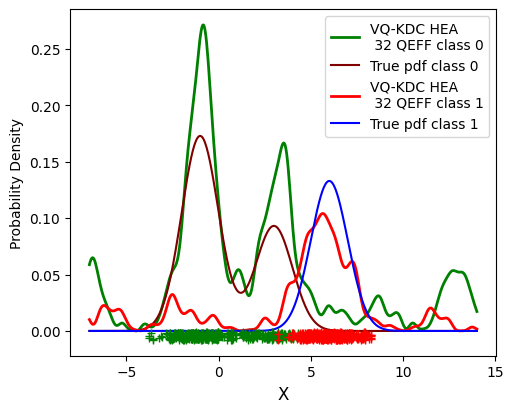

In [223]:
params = {
   'axes.labelsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [5.5, 4.5]
   }
plt.rcParams.update(params)

#plt.plot(X_plot[:, 0], true_dens, "maroon", label='True pdf')
colors = ['navy']
kernels = ['gaussian']
lw = 2
plt.plot(X_plot, preds_plot_vqkdc_qeff_hea[:, 0], color='green', lw=lw,
           linestyle='-', label=f"VQ-KDC HEA \n {2**NUM_QUBITS_FFS} QEFF class 0")
plt.plot(X_plot, true_dens_0, "maroon", label='True pdf class 0')
plt.plot(X_plot, preds_plot_vqkdc_qeff_hea[:, 1], color='red', lw=lw,
           linestyle='-', label=f"VQ-KDC HEA \n {2**NUM_QUBITS_FFS} QEFF class 1")
plt.plot(X_plot, true_dens_1, "blue", label='True pdf class 1')
indexes_class0 = np.random.randint(0, len(X_1), 500)
plt.plot(X_1[indexes_class0], -0.00125 - 0.00675 * np.random.random(len(indexes_class0)), '+g')
indexes_class1 = np.random.randint(0, len(X_2), 500)
plt.plot(X_2[indexes_class1], -0.00125 - 0.00675 * np.random.random(len(indexes_class1)), '+r')
plt.legend(loc='best')
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=10)

### Evaluate

In [224]:
### evaluate metrics
evaluate_class_model(y_true_param = y_train_oh.numpy(), y_train_vqkdc = preds_train_vqkdc_qeff_hea, y_train_kdc = preds_train_kdc, y_train_dmkdc = preds_train_dmkdc_qeff, y_plot_expected_kdc = preds_plot_kdc, y_plot_expected_dmkdc = preds_plot_dmkdc_qeff, y_plot_pred = preds_plot_vqkdc_qeff_hea, grid_size_param = GRID_SIZE, head = f"VQ-KDC {2**NUM_QUBITS_FFS} QEFF vs KDC and DMKDC")

Metrics                            VQ-KDC 32 QEFF vs KDC and DMKDC
-------------------------------  ---------------------------------
Accuracy:                                                    0.964
Negative Log-likelihood KDC:                                 2.428
Negative Log-likelihood DMKDC:                               2.311
Negative Log-likelihood VQ-KDC:                              2.332
KL-div KDC vs DMKDC:                                        -0.277
KL-div KDC vs VQ-KDC:                                       -0.105
KL-div DMKDC vs VQ-KDC:                                      0.608 



# Draft code

In [ ]:
import numpy as np

def negative_log_likelihood_one_hot(y_true, y_pred):
    """
    Compute the Negative Log Likelihood loss for one-hot encoded labels.

    Parameters:
    y_true (numpy.ndarray): One-hot encoded true labels, shape (n_samples, n_classes).
    y_pred (numpy.ndarray): Predicted probabilities, shape (n_samples, n_classes).

    Returns:
    float: Negative Log Likelihood loss.
    """
    # Ensure y_pred is within (0, 1) to avoid log(0)
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, np.inf)

    # Calculate the negative log likelihood
    nll = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    return nll

print("Negative Log Likelihood:", negative_log_likelihood_one_hot(y_train_oh.numpy(), preds_train_kdc))

Negative Log Likelihood: 2.4275419965826455


In [ ]:
def kl_divergence(p, q):
    """
    Compute the Kullback-Leibler Divergence between two probability distributions.

    Parameters:
    p (numpy.ndarray): True probability distribution (n_samples, n_classes).
    q (numpy.ndarray): Approximating probability distribution (n_samples, n_classes).

    Returns:
    float: Kullback-Leibler Divergence.
    """
    # Ensure the distributions are valid (i.e., within (0, 1) and sum to 1)
    epsilon = 1e-15
    p = np.clip(p, epsilon, np.inf)
    q = np.clip(q, epsilon, np.inf)

    # Normalize the distributions to ensure they sum to 1
    #p = p / np.sum(p, axis=1, keepdims=True)
    #q = q / np.sum(q, axis=1, keepdims=True)

    # Calculate the KL Divergence
    kl_div = np.sum(p * np.log(p / q), axis=1)

    return np.sum(kl_div)

kl_div = kl_divergence(preds_plot_dmkdc, preds_plot)*GRID_SIZE
kl_div

array([-0.10263675])